# Training a 3D U-Net

TensorFlow 2 code to train a 3D U-Net on the brain tumor segmentation ([BraTS](https://www.med.upenn.edu/sbia/brats2017.html)) subset of the [Medical Segmentation Decathlon dataset](http://medicaldecathlon.com/) dataset. 

This model can achieve a [Dice coefficient](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1415224/) of > 0.80 on the whole tumor using just the [FLAIR](https://en.wikipedia.org/wiki/Fluid-attenuated_inversion_recovery) channel.

In [14]:
#!python -m venv openvino_env
!openvino_env\Scripts\activate
#!python -m pip install --upgrade pip
#!pip install openvino==2023.0.1
!pip install nibabel
!pip install matplotlib
#!mo --saved_model_dir ./3d_unet_decathlon_final --batch 1 --model_name 3d_unet_decathlon --output_dir ./openvino_models/FP32

In [15]:
import tensorflow as tf
from tensorflow import keras as K

import nibabel as nib
import numpy as np
import os
import datetime
    
import matplotlib.pyplot as plt
%matplotlib inline

## Determine if we are using Intel-optimized TensorFlow (DNNL)

In [16]:
def test_intel_tensorflow():
    """
    Check if Intel version of TensorFlow is installed
    """
    import tensorflow as tf

    print("We are using Tensorflow version {}".format(tf.__version__))

    major_version = int(tf.__version__.split(".")[0])
    if major_version >= 2:
        from tensorflow.python import _pywrap_util_port
        print("Intel-optimizations (DNNL) enabled:",
              _pywrap_util_port.IsMklEnabled())
    else:
        print("Intel-optimizations (DNNL) enabled:",
              tf.pywrap_tensorflow.IsMklEnabled())


#test_intel_tensorflow()  # Prints if Intel-optimized TensorFlow is used.

## Define the settings

In [17]:
data_path="../data/decathlon/Task01_BrainTumour/"
train_val_split = 0.80
val_test_split = 0.50
bz_train=8
bz_val=4
bz_test=1
num_epochs=30

crop_dim = (128,128,128,1)
number_output_classes = 3

filters=8
saved_model_name = "3d_unet_decathlon"

seed=816


## Define a data loader

We'll use `tf.data` to define a way to load the BraTS dataset at runtime whenever a new batch of 3D images and masks are requested.

In [18]:
class DatasetGenerator:
        
    def __init__(self, data_path):
        
        self.data_path = data_path
        self.create_file_list()

    def create_file_list(self):
        """
        Get list of the files from the BraTS raw data
        Split into training and testing sets.
        """
        import os
        import json
        
        json_filename = os.path.join(self.data_path, "dataset.json")

        try:
            with open(json_filename, "r") as fp:
                experiment_data = json.load(fp)
        except IOError as e:
            print("File {} doesn't exist. It should be part of the "
                  "Decathlon directory".format(json_filename))

        self.output_channels = experiment_data["labels"]
        self.input_channels = experiment_data["modality"]
        self.description = experiment_data["description"]
        self.name = experiment_data["name"]
        self.release = experiment_data["release"]
        self.license = experiment_data["licence"]
        self.reference = experiment_data["reference"]
        self.tensorImageSize = experiment_data["tensorImageSize"]
        self.numFiles = experiment_data["numTraining"]
        
        """
        Create a dictionary of tuples with image filename and label filename
        """
        self.filenames = {}
        for idx in range(self.numFiles):
            self.filenames[idx] = [os.path.join(self.data_path,
                                              experiment_data["training"][idx]["image"]),
                                    os.path.join(self.data_path,
                                              experiment_data["training"][idx]["label"])]
            
        
    def print_info(self):
        """
        Print the dataset information
        """

        print("="*30)
        print("Dataset name:        ", self.name)
        print("Dataset description: ", self.description)
        print("Tensor image size:   ", self.tensorImageSize)
        print("Dataset release:     ", self.release)
        print("Dataset reference:   ", self.reference)
        print("Input channels:      ", self.input_channels)
        print("Output labels:       ", self.output_channels)
        print("Dataset license:     ", self.license)
        print("="*30)
        

In [19]:
brats_datafiles = DatasetGenerator(data_path)
brats_datafiles.print_info()

Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Dataset license:      CC-BY-SA 4.0


## Data preprocessing

Here we preprocess the 3D MRI scans. We'll normalize the images, crop the images, and do random flips/rotations.

In [20]:
def z_normalize_img(img):
    """
    Normalize the image so that the mean value for each image
    is 0 and the standard deviation is 1.
    """
    for channel in range(img.shape[-1]):

        img_temp = img[..., channel]
        img_temp = (img_temp - np.mean(img_temp)) / np.std(img_temp)

        img[..., channel] = img_temp

    return img
    
def crop(img, msk, randomize):
        """
        Randomly crop the image and mask
        """

        slices = []
        
        # Do we randomize?
        is_random = randomize and np.random.rand() > 0.5

        for idx in range(len(img.shape)-1):  # Go through each dimension

            cropLen = crop_dim[idx]
            imgLen = img.shape[idx]

            start = (imgLen-cropLen)//2

            ratio_crop = 0.20  # Crop up this this % of pixels for offset
            # Number of pixels to offset crop in this dimension
            offset = int(np.floor(start*ratio_crop))

            if offset > 0:
                if is_random:
                    start += np.random.choice(range(-offset, offset))
                    if ((start + cropLen) > imgLen):  # Don't fall off the image
                        start = (imgLen-cropLen)//2
            else:
                start = 0

            slices.append(slice(start, start+cropLen))

        return img[tuple(slices)], msk[tuple(slices)]
    
def augment_data(img, msk, crop_dim):
    """
    Data augmentation
    Flip image and mask. Rotate image and mask.
    """
    
    # Determine if axes are equal and can be rotated
    # If the axes aren't equal then we can't rotate them.
    equal_dim_axis = []
    for idx in range(0, len(crop_dim)):
        for jdx in range(idx+1, len(crop_dim)):
            if crop_dim[idx] == crop_dim[jdx]:
                equal_dim_axis.append([idx, jdx])  # Valid rotation axes
    dim_to_rotate = equal_dim_axis

    if np.random.rand() > 0.5:
        # Random 0,1 (axes to flip)
        ax = np.random.choice(np.arange(len(crop_dim)-1))
        img = np.flip(img, ax)
        msk = np.flip(msk, ax)

    elif (len(dim_to_rotate) > 0) and (np.random.rand() > 0.5):
        rot = np.random.choice([1, 2, 3])  # 90, 180, or 270 degrees

        # This will choose the axes to rotate
        # Axes must be equal in size
        random_axis = dim_to_rotate[np.random.choice(len(dim_to_rotate))]
        
        img = np.rot90(img, rot, axes=random_axis)  # Rotate axes 0 and 1
        msk = np.rot90(msk, rot, axes=random_axis)  # Rotate axes 0 and 1

    return img, msk
    
def read_nifti_file(idx, crop_dim, randomize=False):
    """
    Read Nifti file
    """
    
    idx = idx.numpy()
    imgFile = brats_datafiles.filenames[idx][0]
    mskFile = brats_datafiles.filenames[idx][1]
    
    img = np.array(nib.load(imgFile).dataobj)
    
    img = np.rot90(img[...,[0]]) # Just take the FLAIR channel (0)
    
    msk = np.rot90(np.array(nib.load(mskFile).dataobj))

    """
    "labels": {
         "0": "background",
         "1": "edema",
         "2": "non-enhancing tumor",
         "3": "enhancing tumour"}
     """
    # Combine all masks but background
    if number_output_classes == 1:
        msk[msk > 0] = 1.0
        msk = np.expand_dims(msk, -1)
    else:
        msk_temp = np.zeros(list(msk.shape) + [number_output_classes])
        for channel in range(number_output_classes):
            msk_temp[msk==channel,channel] = 1.0
        msk = msk_temp
    
    imgFilename = (os.path.basename(brats_datafiles.filenames[idx][0])).split(".nii.gz")[0]
    
    # Crop
    img, msk = crop(img, msk, randomize)
    
    # Normalize
    img = z_normalize_img(img)
    
    # Randomly rotate
    if randomize:
        img, msk = augment_data(img, msk, crop_dim)
    
    return img, msk
    

## tf.data

Define the training, testing, and validation data loaders.

In [21]:
numFiles = brats_datafiles.numFiles
numTrain = int(numFiles * train_val_split)
numValTest = numFiles - numTrain

ds = tf.data.Dataset.range(numFiles).shuffle(numFiles, seed) # Shuffle the dataset

ds_train = ds.take(numTrain)
ds_val_test = ds.skip(numTrain)
ds_val = ds_val_test.take(int(numValTest * val_test_split))
ds_test = ds_val_test.skip(int(numValTest * val_test_split))

ds_train = ds_train.map(lambda x: tf.py_function(read_nifti_file, [x, crop_dim, True], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(lambda x: tf.py_function(read_nifti_file, [x, crop_dim, False], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(lambda x: tf.py_function(read_nifti_file, [x, crop_dim, False], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.batch(bz_train)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = ds_val.batch(bz_val)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.batch(bz_test)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


## Plot some data samples

Plots the MRI and Tumor Masks from a few data samples.

Mean pixel value = -2.3702159523963928e-07


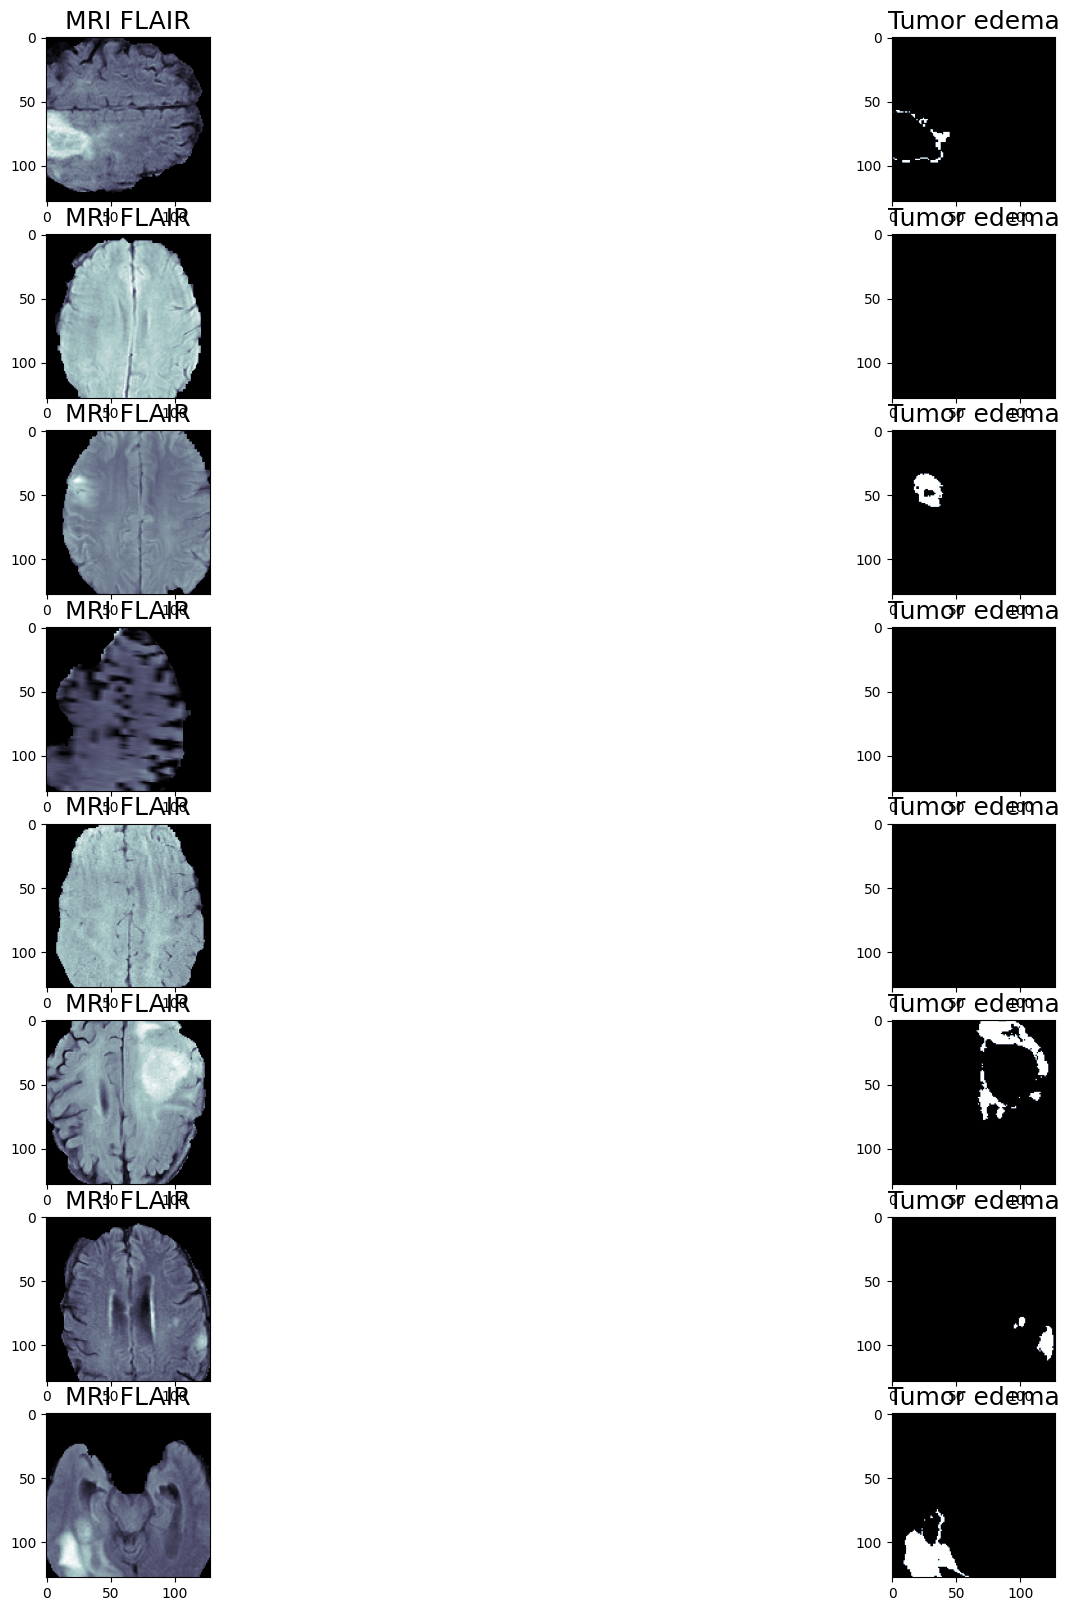

In [22]:
plt.figure(figsize=(20,20))

num_cols=2
slice_num = 91

msk_channel=1
img_channel=0 

for img, msk in ds_train.take(1):
    bs = img.shape[0]
    
    for idx in range(bs):
          
        plt.subplot(bs,num_cols,idx*num_cols + 1)
        plt.imshow(img[idx,:,:,slice_num,img_channel], cmap="bone")
        plt.title("MRI {}".format(brats_datafiles.input_channels[str(img_channel)]), fontsize=18)
        plt.subplot(bs,num_cols,idx*num_cols + 2)
        plt.imshow(msk[idx,:,:,slice_num,msk_channel], cmap="bone")
        plt.title("Tumor {}".format(brats_datafiles.output_channels[str(msk_channel)]), fontsize=18)
        
print("Mean pixel value = {}".format(np.mean(img[0,:,:,:,0])))

Mean pixel value = -5.360925570130348e-08


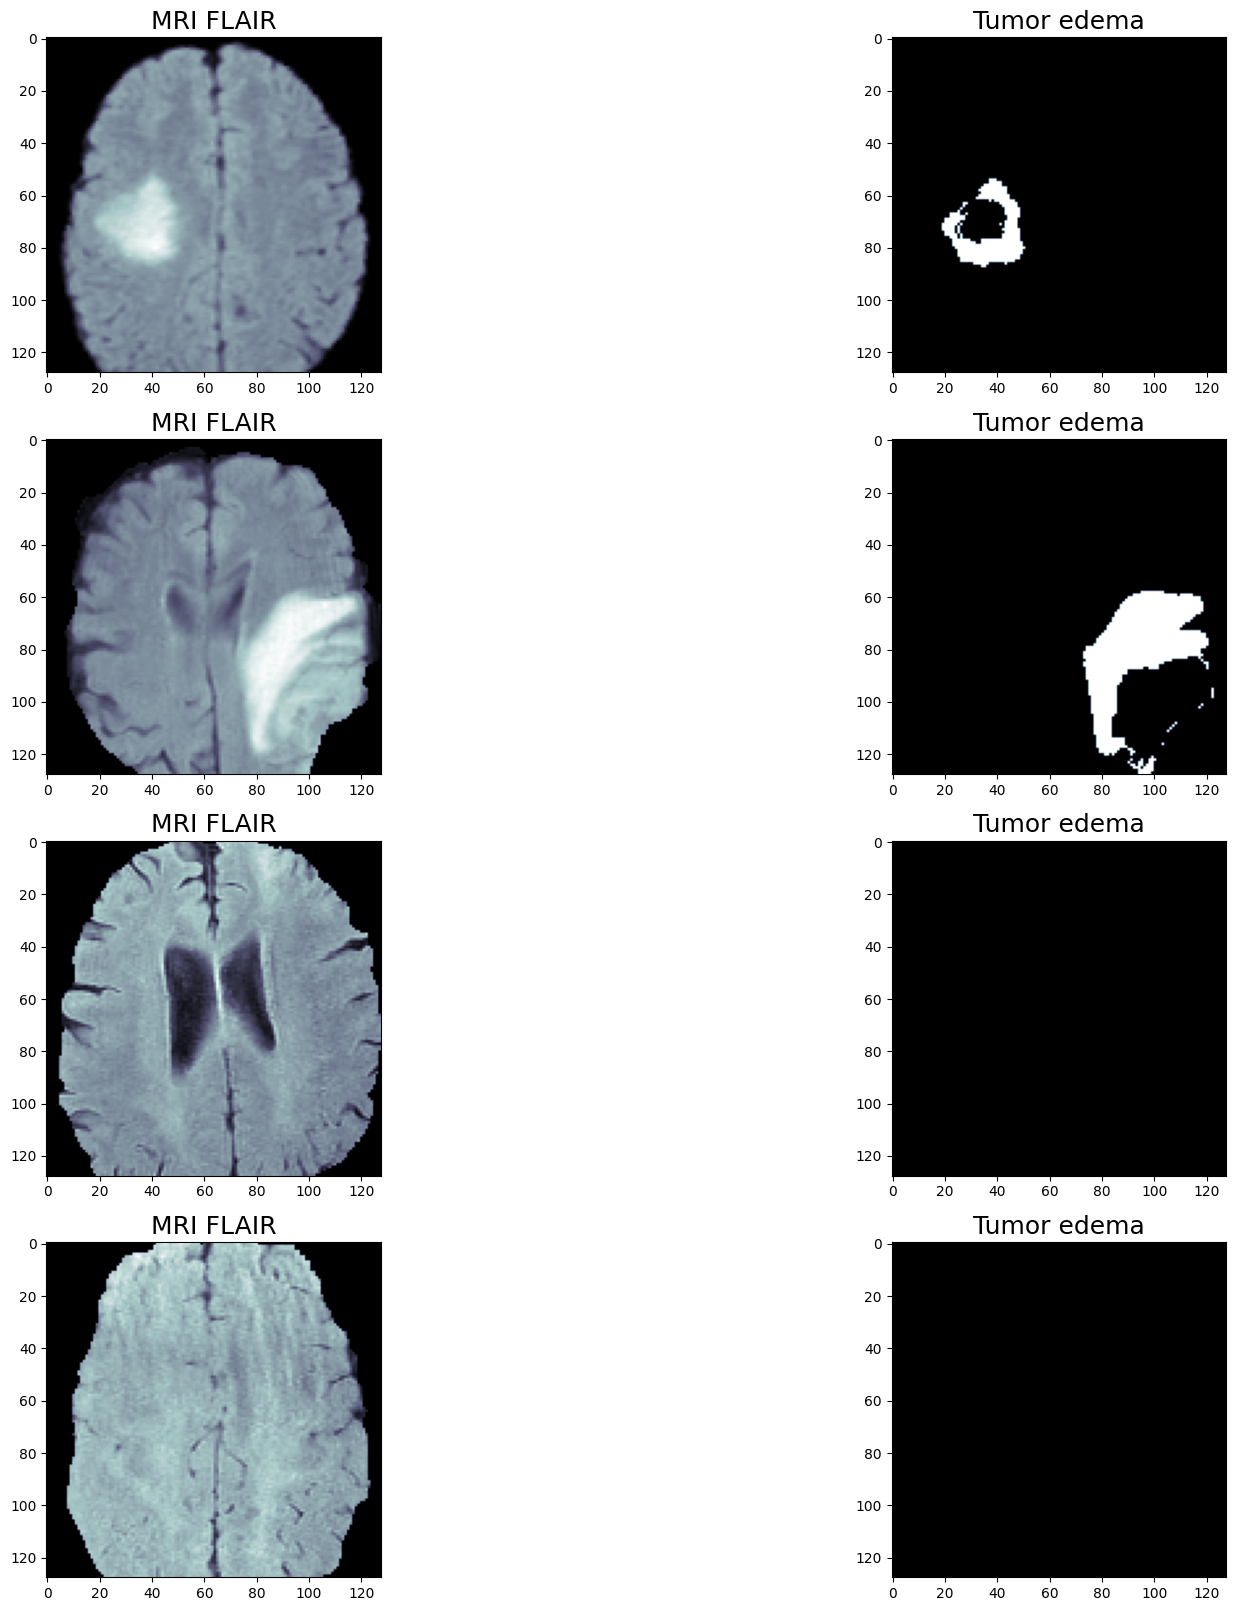

In [23]:
plt.figure(figsize=(20,20))

num_cols=2
slice_num = 91

msk_channel=1
img_channel=0 

for img, msk in ds_val.take(1):
    bs = img.shape[0]
    
    for idx in range(bs):
        
        plt.subplot(bs,num_cols,idx*num_cols + 1)
        plt.imshow(img[idx,:,:,slice_num,img_channel], cmap="bone")
        plt.title("MRI {}".format(brats_datafiles.input_channels[str(img_channel)]), fontsize=18)
        plt.subplot(bs,num_cols,idx*num_cols + 2)
        plt.imshow(msk[idx,:,:,slice_num,msk_channel], cmap="bone")
        plt.title("Tumor {}".format(brats_datafiles.output_channels[str(msk_channel)]), fontsize=18)
   
print("Mean pixel value = {}".format(np.mean(img[0,:,:,:,0])))

Mean pixel value = 2.2765016183257103e-07


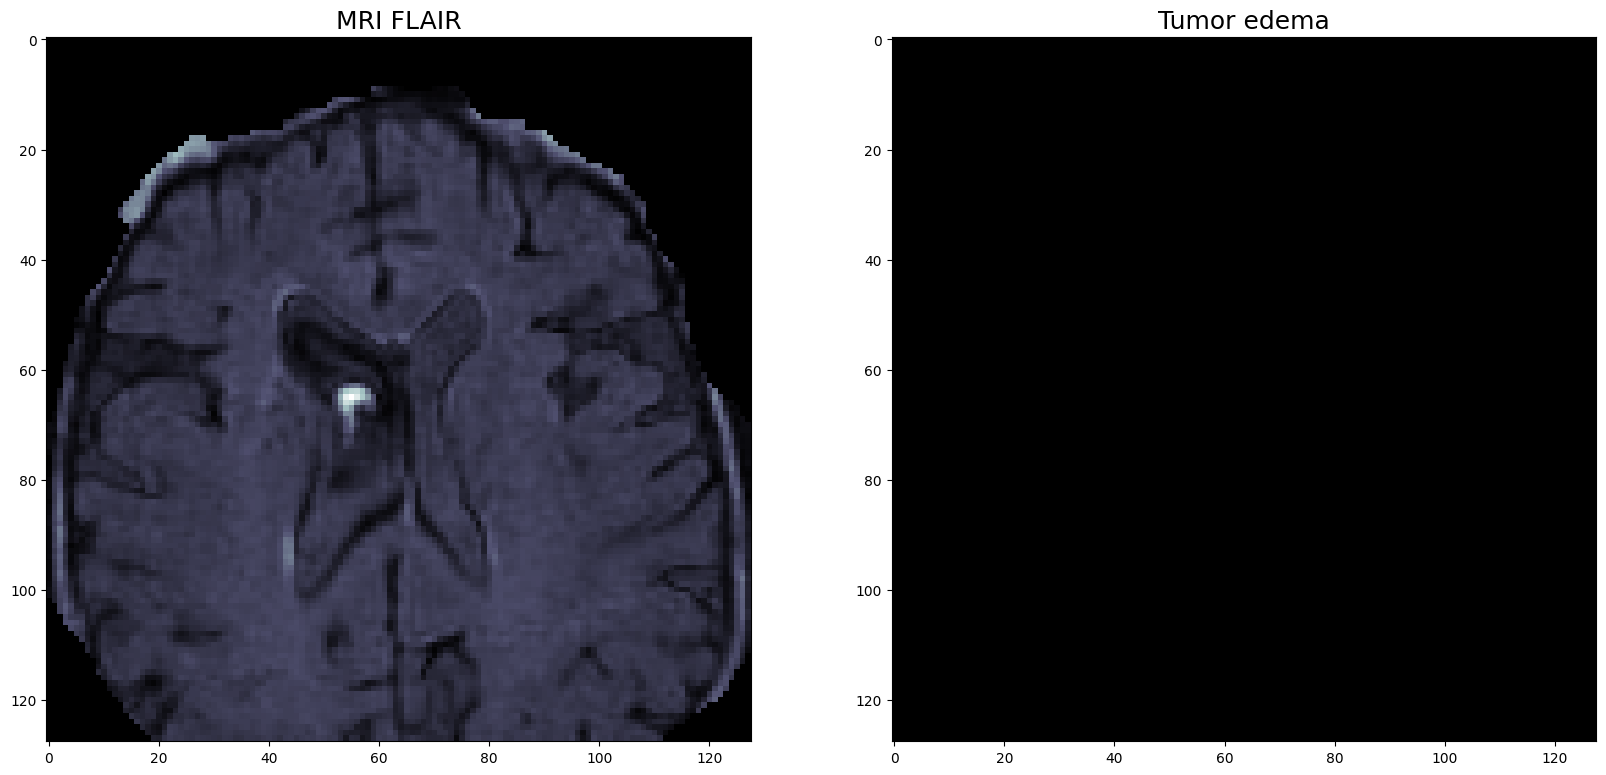

In [24]:
plt.figure(figsize=(20,20))

num_cols=2
slice_num = 91

msk_channel=1
img_channel=0 

for img, msk in ds_test.take(1):
    bs = img.shape[0]
    
    for idx in range(bs):
          
        plt.subplot(bs,num_cols,idx*num_cols + 1)
        plt.imshow(img[idx,:,:,slice_num,img_channel], cmap="bone")
        plt.title("MRI {}".format(brats_datafiles.input_channels[str(img_channel)]), fontsize=18)
        plt.subplot(bs,num_cols,idx*num_cols + 2)
        plt.imshow(msk[idx,:,:,slice_num,msk_channel], cmap="bone")
        plt.title("Tumor {}".format(brats_datafiles.output_channels[str(msk_channel)]), fontsize=18)
   
        
print("Mean pixel value = {}".format(np.mean(img[0,:,:,:,0])))

## Define the loss and metrics

In [25]:
def dice_coef(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    prediction = tf.round(prediction)  # Round to 0 or 1

    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)

def soft_dice_coef(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson (Soft) Dice - Don't round predictions
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def dice_loss(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson (Soft) Dice loss
    Using -log(Dice) as the loss since it is better behaved.
    Also, the log allows avoidance of the division which
    can help prevent underflow when the numbers are very small.
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.math.log(2.*numerator) + tf.math.log(denominator)

    return dice_loss


## Define the 3D U-Net

Create a TensorFlow model.

In [26]:
def unet_3d(fms=32, input_dim=crop_dim, use_upsampling=False, concat_axis=-1):
    """
    3D U-Net
    """
    
    def ConvolutionBlock(x, name, fms, params):
        """
        Convolutional block of layers
        Per the original paper this is back to back 3D convs
        with batch norm and then ReLU.
        """

        x = K.layers.Conv3D(filters=fms, **params, name=name+"_conv0")(x)
        x = K.layers.BatchNormalization(name=name+"_bn0")(x)
        x = K.layers.Activation("relu", name=name+"_relu0")(x)

        x = K.layers.Conv3D(filters=fms, **params, name=name+"_conv1")(x)
        x = K.layers.BatchNormalization(name=name+"_bn1")(x)
        x = K.layers.Activation("relu", name=name)(x)

        return x

    inputs = K.layers.Input(shape=input_dim, name="MRImages")

    params = dict(kernel_size=(3, 3, 3), activation=None,
                  padding="same", 
                  kernel_initializer="he_uniform")

    # Transposed convolution parameters
    params_trans = dict(kernel_size=(2, 2, 2), strides=(2, 2, 2),
                        padding="same")


    # BEGIN - Encoding path
    encodeA = ConvolutionBlock(inputs, "encodeA", fms, params)
    poolA = K.layers.MaxPooling3D(name="poolA", pool_size=(2, 2, 2))(encodeA)

    encodeB = ConvolutionBlock(poolA, "encodeB", fms*2, params)
    poolB = K.layers.MaxPooling3D(name="poolB", pool_size=(2, 2, 2))(encodeB)

    encodeC = ConvolutionBlock(poolB, "encodeC", fms*4, params)
    poolC = K.layers.MaxPooling3D(name="poolC", pool_size=(2, 2, 2))(encodeC)

    encodeD = ConvolutionBlock(poolC, "encodeD", fms*8, params)
    poolD = K.layers.MaxPooling3D(name="poolD", pool_size=(2, 2, 2))(encodeD)

    encodeE = ConvolutionBlock(poolD, "encodeE", fms*16, params)
    # END - Encoding path

    # BEGIN - Decoding path
    if use_upsampling:
        up = K.layers.UpSampling3D(name="upE", size=(2, 2, 2),
                                   interpolation="bilinear")(encodeE)
    else:
        up = K.layers.Conv3DTranspose(name="transconvE", filters=fms*8,
                                      **params_trans)(encodeE)
    concatD = K.layers.concatenate(
        [up, encodeD], axis=concat_axis, name="concatD")

    decodeC = ConvolutionBlock(concatD, "decodeC", fms*8, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="upC", size=(2, 2, 2),
                                   interpolation="bilinear")(decodeC)
    else:
        up = K.layers.Conv3DTranspose(name="transconvC", filters=fms*4,
                                      **params_trans)(decodeC)
    concatC = K.layers.concatenate(
        [up, encodeC], axis=concat_axis, name="concatC")

    decodeB = ConvolutionBlock(concatC, "decodeB", fms*4, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="upB", size=(2, 2, 2),
                                   interpolation="bilinear")(decodeB)
    else:
        up = K.layers.Conv3DTranspose(name="transconvB", filters=fms*2,
                                      **params_trans)(decodeB)
    concatB = K.layers.concatenate(
        [up, encodeB], axis=concat_axis, name="concatB")

    decodeA = ConvolutionBlock(concatB, "decodeA", fms*2, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="upA", size=(2, 2, 2),
                                   interpolation="bilinear")(decodeA)
    else:
        up = K.layers.Conv3DTranspose(name="transconvA", filters=fms,
                                      **params_trans)(decodeA)
    concatA = K.layers.concatenate(
        [up, encodeA], axis=concat_axis, name="concatA")

    # END - Decoding path

    convOut = ConvolutionBlock(concatA, "convOut", fms, params)

    prediction = K.layers.Conv3D(name="PredictionMask",
                                 filters=number_output_classes, kernel_size=(1, 1, 1),
                                 activation="sigmoid")(convOut)

    model = K.models.Model(inputs=[inputs], outputs=[prediction], name="3d_unet_decathlon")

    model.summary()

    return model


In [27]:
model = unet_3d(fms=filters, input_dim=crop_dim)

model.compile(loss=dice_loss, metrics=[dice_coef, soft_dice_coef], optimizer="adam")

Model: "3d_unet_decathlon"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MRImages (InputLayer)       [(None, 128, 128, 128, 1)]   0         []                            
                                                                                                  
 encodeA_conv0 (Conv3D)      (None, 128, 128, 128, 8)     224       ['MRImages[0][0]']            
                                                                                                  
 encodeA_bn0 (BatchNormaliz  (None, 128, 128, 128, 8)     32        ['encodeA_conv0[0][0]']       
 ation)                                                                                           
                                                                                                  
 encodeA_relu0 (Activation)  (None, 128, 128, 128, 8)     0         ['encodeA_bn0[

## Define the training callbacks

This includes model checkpoints and TensorBoard logs.

In [28]:
checkpoint = K.callbacks.ModelCheckpoint(saved_model_name,
                                         verbose=1,
                                         save_best_only=True)

# TensorBoard
logs_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_logs = K.callbacks.TensorBoard(log_dir=logs_dir)

callbacks = [checkpoint, tb_logs]


In [29]:
%load_ext tensorboard

In [30]:
%tensorboard --logdir logs 

## Train the model

In [31]:
model.fit(ds_train, epochs=num_epochs, validation_data=ds_val, callbacks=callbacks)

Epoch 1/30


KeyboardInterrupt: 

## Evaluate the model

Evaluate the final model on the test dataset. This gives us an idea of how the model should perform on data it has never seen.

In [ ]:
loss, dice_coef, soft_dice_coef = model.evaluate(ds_test)

print("Average Dice Coefficient on test dataset = {:.4f}".format(dice_coef))

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0*

*Copyright (c) 2019-2020 Intel Corporation*